# Inductive bias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import sys 
from importlib import reload
sys.path.append("..//1_Interpolation")
import E1_Functions as func

# Define a discrete color palette with a specified number of colors
#sns.set_palette(sns.color_palette("muted", n_colors=10))  # or use another color map and adjust `n_colors`
custom_palette = ["#FFB347", "#779ECB", "#77DD77", "#FF6961", "#CB99C9", "#FDFD96", "#AEC6CF"]
costum_palette_pairs = ['#ffb347', '#ffcc84', '#ffe6c2', 
                        '#779ecb', '#a4bedc', '#d2dfee', 
                        '#77dd77', '#a4e8a4', '#d2f4d2', 
                        '#ff6961', '#ff9b96', '#ffcdca', 
                        '#cb99c9', '#dcbbdb', '#eedded', 
                        '#fdfd96', '#fefeb9', '#fefedc',
                        '#aec6cf', '#c9d9df', '#e4ecef']

sns.set_palette(custom_palette)
colors = sns.color_palette()
colors_pairs = sns.color_palette(costum_palette_pairs) #("tab20c")

# set title font size
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Enable LaTeX font rendering
#plt.rcParams.update({
#    "text.usetex": True,            # Use LaTeX for all text
#    "font.family": "serif",         # Set the font family to serif (LaTeX default)
#    "font.serif": ["Computer Modern"]  # Use Computer Modern font (LaTeX default font)
#})


In [2]:
# set random seed 
seed = 18
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
save_results = False
save_plots = False

In [4]:
# Helper Function: Analytical solution to the 1D underdamped harmonic oscillator
def oscillator(d, w0, x):
    """Analytical solution to the 1D underdamped harmonic oscillator."""
    assert d < w0, "Damping coefficient must be less than angular frequency for underdamped motion."
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    y = torch.exp(-d * x) * 2 * A * torch.cos(phi + w * x)
    return y

# Updated generate_data function
def generate_data(num_points, noise_std=0.3, n_waves=15, shifted=False, d=0, w0=1):
    # Generate train_x in the specified range
    train_x = np.linspace(-n_waves * np.pi, n_waves * np.pi, num_points)
    train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
    
    # Generate train_y using the oscillator function and add noise
    train_y = oscillator(d, w0, train_x_tensor).numpy() + np.random.normal(0, noise_std, num_points)

    if shifted:  # For shifted test data
        test_x = np.linspace(n_waves * np.pi, 5 * n_waves * np.pi, 100)
    else:        # For non-shifted test data
        test_x = np.linspace(-n_waves * np.pi, n_waves * np.pi, 100)

    test_x_tensor = torch.tensor(test_x, dtype=torch.float32)
    test_y = oscillator(d, w0, test_x_tensor).numpy()

    return train_x, train_y, test_x, test_y

# Example

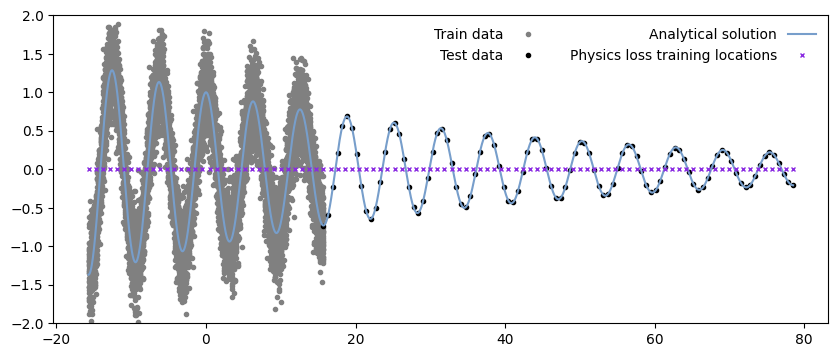

In [5]:
N_train_snake = 10000 #4000
N_train_pinn = 9900
N_physics = 100

batch_size = 25
input_size, hidden_sizes, output_size = 1, [64, 64], 1
print_every = 300
lr = 0.01


# Parameters for sine wave dataset
noise_std = 0.3
n_waves = 5 #6
d = 0.02    # Damping coefficient (must be less than w0)
w0 = 1.0   # Angular frequency
mu, k = 2*d, w0**2

# Generate data for snake
train_x_array_snake, train_y_array_snake, test_x_array, test_y_array = generate_data(N_train_snake, noise_std, n_waves, shifted=True, d=d, w0=w0)
train_x_snake, train_y_snake, test_x, test_y = func.convert_to_tensor(train_x_array_snake, train_y_array_snake, test_x_array, test_y_array)
train_loader_snake = func.create_dataloader(train_x_snake, train_y_snake, batch_size=batch_size)

# generate data for pinn
train_x_array_pinn, train_y_array_pinn, _, _ = generate_data(N_train_pinn, noise_std, n_waves, shifted=True, d=d, w0=w0)
train_x_pinn, train_y_pinn, _, _ = func.convert_to_tensor(train_x_array_pinn, train_y_array_pinn, test_x_array, test_y_array)
train_loader_pinn = func.create_dataloader(train_x_pinn, train_y_pinn, batch_size=batch_size)


# plot analytical solution on top of training data
x = torch.linspace(-n_waves * np.pi, 5 * n_waves * np.pi, N_train_snake)
x_physics = torch.linspace(-n_waves * np.pi, 5 * n_waves * np.pi, N_physics).requires_grad_(True)
y = oscillator(d, w0, x)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(train_x_array_snake, train_y_array_snake, label='Train data', color='grey', marker='o', ms=3, ls='')
ax.plot(test_x_array, test_y_array, label='Test data', color='black', marker='o', ms=3, ls='')
ax.plot(x, y, label='Analytical solution', color=colors[1])
ax.plot(x_physics.detach().numpy(), torch.zeros_like(x_physics), label='Physics loss training locations', color='blueviolet', marker='x', ms=3, ls='')
ax.legend(loc='upper right', frameon=False, markerfirst=False, ncols=2)
#ax.axvspan(-3 * np.pi, 3 * np.pi, color='grey', alpha=0.2)
#ax.set_xlim(-3 * np.pi, 9 * np.pi)
ax.set_ylim(-2, 2.)
#ax.set_xticks(np.arange(-3, 12, 3)*np.pi, labels=[f"${i}\pi$" for i in np.arange(-3, 12, 3)])
plt.show()

# Snake training

In [6]:
###### SnakeMLP ######
num_epochs = 100

snake_train_pred = []
snake_test_pred = []

for i in range(10):
    SnakeMLP = func.SnakeMLP(input_size, hidden_sizes, output_size)
    model_SnakeMLP, train_losses_SnakeMLP, val_losses_SnakeMLP = func.train_model(SnakeMLP, train_loader_snake, test_x, test_y, lr, num_epochs=num_epochs, print_every=print_every)

    model_SnakeMLP.eval()
    with torch.no_grad():
        model_SnakeMLP.eval()
        train_pred_snake = model_SnakeMLP(train_x_snake).numpy().squeeze()
        test_pred_snake = model_SnakeMLP(test_x).numpy().squeeze()
        snake_train_pred.append(train_pred_snake)
        snake_test_pred.append(test_pred_snake)

    #fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    #ax.plot(train_losses_SnakeMLP, label='Snake train', color=colors[3])
    #ax.plot(val_losses_SnakeMLP, label='Snake validation', ls = '--', color=colors[3], alpha=0.5)
    #ax.set_xlabel('Epoch')
    #ax.set_ylabel('Loss')
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.legend(loc='lower left', frameon=False, ncols=4)
    #ax.set_xlim(1, num_epochs)
    ##ax.set_ylim(1e-3, 1e2)
    #plt.tight_layout()

# PINN training

In [7]:
###### PINN ######
num_epochs = 100

pinn_train_pred = []
pinn_test_pred = []

for i in range(10):
    model = func.SnakeMLP(input_size, hidden_sizes, output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    x_physics = x_physics.view(-1, 1)

    

    with tqdm(total=num_epochs) as pbar:
        for step in range(num_epochs):
            model.train()
            for inputs, targets in train_loader_pinn:
                optimizer.zero_grad()

                # Data Loss
                outputs_data = model(inputs)
                loss_data = criterion(outputs_data, targets)
                # Physics Loss
                outputs_physics = model(x_physics)
                dx = torch.autograd.grad(outputs_physics, x_physics, torch.ones_like(outputs_physics), create_graph=True)[0]
                dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
                physics = dx2 + mu * dx + k * outputs_physics
                loss_physics = torch.mean(physics**2)
                
                # Total Loss
                loss = loss_physics + loss_data
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            
            # Update Progress Bar
            pbar.update(1)

    # Evaluation
    with torch.no_grad():
        model.eval()
        train_pred_pinn = model(train_x_pinn).detach().numpy().squeeze()
        test_pred_pinn = model(test_x).detach().numpy().squeeze()
        pinn_train_pred.append(train_pred_pinn)
        pinn_test_pred.append(test_pred_pinn)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


# Results

In [14]:
# convert to numpy arrays
snake_train_pred = np.array(snake_train_pred)
snake_test_pred = np.array(snake_test_pred)
pinn_train_pred = np.array(pinn_train_pred)
pinn_test_pred = np.array(pinn_test_pred)

# Save results
if save_results:
    np.save('DHO_snake_train_pred.npy', snake_train_pred)
    np.save('DHO_snake_test_pred.npy', snake_test_pred)
    np.save('DHO_pinn_train_pred.npy', pinn_train_pred)
    np.save('DHO_pinn_test_pred.npy', pinn_test_pred)
    

In [8]:
save_results = True

In [13]:
mean = pd.DataFrame(columns=['Snake', 'PINN'], index=['Train', 'Test'])
std = pd.DataFrame(columns=['Snake', 'PINN'], index=['Train', 'Test'])

mean.loc['Train', 'Snake'] = np.mean(snake_train_pred, axis=0)
mean.loc['Test', 'Snake'] = np.mean(snake_test_pred, axis=0)

mean.loc['Train', 'PINN'] = np.mean(pinn_train_pred, axis=0).squeeze()
mean.loc['Test', 'PINN'] = np.mean(pinn_test_pred, axis=0).squeeze()

std.loc['Train', 'Snake'] = np.std(snake_train_pred, axis=0)
std.loc['Test', 'Snake'] = np.std(snake_test_pred, axis=0)

std.loc['Train', 'PINN'] = np.std(pinn_train_pred, axis=0).squeeze()
std.loc['Test', 'PINN'] = np.std(pinn_test_pred, axis=0).squeeze()

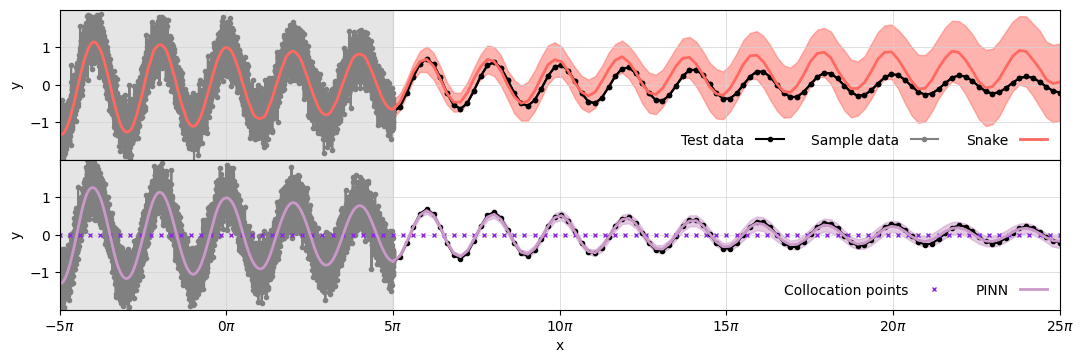

In [12]:
# PLOT RESULTS
# Create a figure and specify GridSpec
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True) #, gridspec_kw={'height_ratios': [2, 1]})


axes[0].plot(test_x_array, test_y_array, label='Test data', color='black', marker='o', ms=3, ls='-')

# only first four axes
for ax in axes:
    ax.grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
    ax.plot(test_x_array, test_y_array, color='black', marker='o', ms=3, ls='-')


lw = 2
alpha = 0.5

axes[0].plot(train_x_array_snake, train_y_array_snake, label='Sample data', color='grey', marker='o', ms=3, ls='-')
axes[0].plot(train_x_array_snake, mean.loc['Train', 'Snake'], label='Snake', color=colors[3], lw=lw)
axes[0].fill_between(train_x_array_snake, mean.loc['Train', 'Snake'] - std.loc['Train', 'Snake'], mean.loc['Train', 'Snake'] + std.loc['Train', 'Snake'], color=colors[3], alpha=alpha)
axes[0].plot(test_x_array, mean.loc['Test', 'Snake'], color=colors[3], ls='-', lw=lw)
axes[0].fill_between(test_x_array, mean.loc['Test', 'Snake'] - std.loc['Test', 'Snake'], mean.loc['Test', 'Snake'] + std.loc['Test', 'Snake'], color=colors[3], alpha=alpha)

axes[1].plot(train_x_array_pinn, train_y_array_pinn, color='grey', marker='o', ms=3, ls='-')
axes[1].plot(x_physics.detach().numpy(), torch.zeros_like(x_physics), label='Collocation points', color='blueviolet', marker='x', ms=3, ls='')
axes[1].plot(train_x_array_pinn, mean.loc['Train', 'PINN'], label='PINN', color=colors[4], lw=lw)
axes[1].fill_between(train_x_array_pinn, mean.loc['Train', 'PINN'] - std.loc['Train', 'PINN'], mean.loc['Train', 'PINN'] + std.loc['Train', 'PINN'], color=colors[4], alpha=alpha)
axes[1].plot(test_x_array, mean.loc['Test', 'PINN'], color=colors[4], ls='-', lw=lw)
axes[1].fill_between(test_x_array, mean.loc['Test', 'PINN'] - std.loc['Test', 'PINN'], mean.loc['Test', 'PINN'] + std.loc['Test', 'PINN'], color=colors[4], alpha=alpha)

# plot physics data

for ax in axes:
    #ax.vlines(5*np.pi, -2, 2, color='black', ls='--', lw=1)
    ax.set_xlim(-5 * np.pi, 25 * np.pi)
    ax.set_ylim(-2, 2.)
    ax.legend(loc='lower right', frameon=False, ncol=3, markerfirst=False)  
    ax.set_ylabel('y')
    ax.set_yticks(np.arange(-1, 2, 1))
    ax.axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)

axes[1].set_xlabel('x')
plt.xticks(np.arange(-5, 26, 5)*np.pi, labels=[f"${i}\pi$" for i in np.arange(-5, 26, 5)])


plt.subplots_adjust(hspace=0, wspace=0) # Remove all spaces between subplots
#plt.tight_layout(pad=0) # Optionally remove padding around the figure
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
#plt.tight_layout()
plt.show()


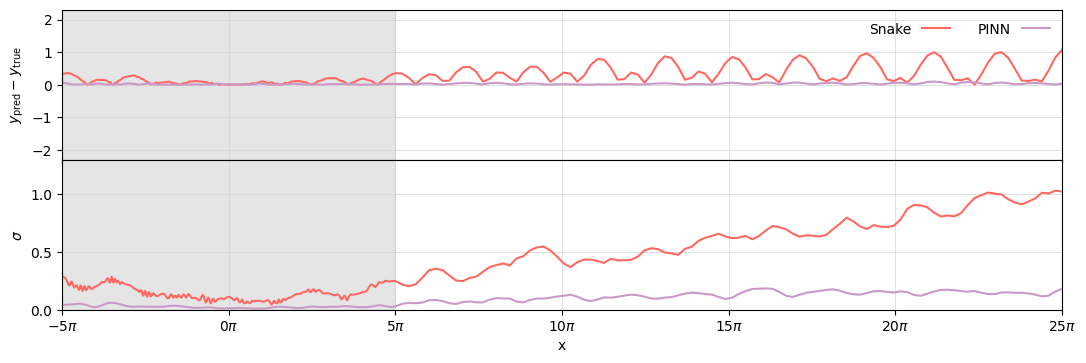

In [11]:
# Define model names and corresponding colors
models = ['Snake', 'PINN']


# Analytical solution
x_combined = np.concatenate([train_x_array_snake, test_x_array])
y_analytical = np.cos(x_combined)
x_combined_pinn = np.concatenate([train_x_array_pinn, test_x_array])
y_analytical_pinn = oscillator(d, w0, torch.tensor(x_combined_pinn)).numpy()



# Compute combined losses and absolute differences
combined_losses = {}
abs_diff_means = {}

# For Snake separately
abs_diff_means['Snake'] = np.abs(
    np.concatenate([mean.loc['Train', 'Snake'], mean.loc['Test', 'Snake']]) - y_analytical
)

# For PINN separately
abs_diff_means['PINN'] = np.abs(
    np.concatenate([mean.loc['Train', 'PINN'], mean.loc['Test', 'PINN']]) - y_analytical_pinn
)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

# Plot absolute difference for each model
axes[0].plot(x_combined, abs_diff_means['Snake'], label='Snake', color=colors[3])
axes[0].plot(x_combined_pinn, abs_diff_means['PINN'], label='PINN', color=colors[4])

# Plot standard deviation for each model
axes[1].plot(x_combined, np.concatenate([std.loc['Train', 'Snake'], std.loc['Test', 'Snake']]), label='Snake', color=colors[3]) 
axes[1].plot(x_combined_pinn, np.concatenate([std.loc['Train', 'PINN'], std.loc['Test', 'PINN']]), label='PINN', color=colors[4])


for ax in axes:
    ax.set_xlim(-5 * np.pi, 25 * np.pi)
    ax.set_xticks(np.arange(-5, 26, 5) * np.pi, labels=[f"${i}\pi$" for i in np.arange(-5, 26, 5)])
    ax.grid(True, color='lightgrey', linestyle='-', linewidth=0.5)
    ax.axvspan(-5 * np.pi, 5 * np.pi, color='grey', alpha=0.2)


# Labels and Legend
axes[0].set_ylabel('$y_{\mathrm{pred}} - y_{\mathrm{true}}$')
#axes[0].set_ylim(-0.5, 1)
#axes[0].set_yticks(np.arange(-0.5, 1.5, 0.5))
axes[0].set_ylim(-2.3, 2.3)

axes[1].set_xlabel('x')
axes[1].set_ylabel('$\sigma$')
axes[1].set_ylim(0, 1.3)
axes[0].legend(loc='upper right', frameon=False, ncol=5, markerfirst=False)

# Adjust layout and show plot
plt.subplots_adjust(hspace=0, wspace=0) 
plt.subplots_adjust(top=1, bottom=0, left=0, right=1)
plt.show()